### ASTR-598, Winter 2018, Connolly & Ivezic, University of Washington
https://github.com/dirac-institute/uw-astr598-w18/tree/master/lectures/Week-5-Tue.ipynb


# Week 5, Tuesday: Model Parameter Estimation and Model Selection in Bayesian Framework. I




##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Jake VanderPlas: ``Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: ``Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: ``Data Analysis: A Bayesian Tutorial''](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: ``Probability Theory: The Logic of Science''](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: ``Confidence Intervals vs. Bayesian intervals''](http://bayes.wustl.edu/etj/articles/confidence.pdf)

##### Topics for this week: 
- Bayesian model parameter estimation 
- Bayesian model selection 
- optimal bin width for classical histograms
- Bayesian Blocks algorithm for optimal histograms 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

![BayesSlide1](figures/bayes2.tiff)

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 
  

 
 
 

Let's now take a look at another example where adequate priors are important and influence the final result: the fitting of a straight line to (x,y) data. 

An excellent discussion of this case can be found in a 
[blog by Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/).

A great reference in that blog is a paper by Jaynes: "Straight Line Fitting: A Bayesian Solution"

In Week 3, we covered MLE approach to fitting a straight line - let's recall what we did.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

$$ y_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the known homoscedastic measurement 
uncertainty for $y$ (and we assume that the uncertainty for x is negligible). 

Assuming the measurements are independent, the likelihood is the product of individual probabilities 
for every $y_i$:

$$ L(a, b) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - a x_i - b)^2}{2 \sigma^2} \right) $$.

and $\ln L$ is equal to:

$$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - a x_i - b)^2.$$

This is the expression that the MLE minimizes with respect to $a$ and $b$ to find ML estimators for those parameters.  

In Bayesian approach we have for the posterior probability

$$ p(a, b \,|\, \{x_i,y_i\}) \propto L(a, b) \, p(a) \, p(b), $$

where $p(a)$ and $p(b)$ are priors for $a$ and $b$. Obviously, if we adopt uniform priors
the MLE values of $a$ and $b$ maximize the posterior probability, too.

** However, the uniform prior for $a$ is not an uninformative prior! **   Let's illustrate this point.

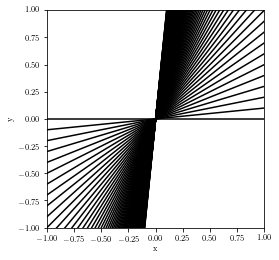

In [2]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
x = np.linspace(-1, 1)

for slope in np.arange(0, 10, 0.1):
    plt.plot(x, slope * x, '-k')

ax.axis([-1, 1, -1, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
plt.show() 

These lines have evenly-spaced slopes in units of 0.1, yet the higher slopes 
are bunched together. Due to this bunching, a flat prior on slope will highly 
favor very steep slopes! A flat prior on slope is not a minimally informative 
prior, and may end up biasing your result for small datasets (with enough data 
the effect vanishes).

An uninformative prior for the slope can be derived by requiring symmetry 
(the same answers) between fitting y vs. x and x vs. y. The result is that

$$   p(a) \propto \frac{1}{(1 + a^2)^{3/2}}. $$

Note that $a$ is the tangent of the angle with the $x$ axis, $\theta$, $a=tan(\theta)$,
and $p(a)$ is
defined for $-\infty < a < \infty$.

We will solve this problem with uninformative and flat priors for $a$ next
week (after we introduce Markov Chain Monte Carlo method and tools). 

And one final simple Bayesian example: the coin flip. 
 

### Parameter estimation for the binomial distribution

If you flip a coin $N$ times and get $k$ tails, the probability of tails, $b$,
can be estimated as $b_o=k/N$. 
For large N, the uncertainty of $b_o$ is approximately Gaussian and given by 
$$ \sigma_b = \left[\frac{b_o \, (1-b_o)}{N}\right]^{1/2}. $$

For small N, we can use Bayesian approach to compute posterior pdf $p(b)$, as follows.

Here the data set $\{x_i\}$ is discrete: all outcomes are either 0 (heads) or 1 (tails, which we will consider “success”). An astronomical analog might be the computation of the fraction of galaxies which show evidence for a black hole in their center. 

Given a model parametrized by the probability of success (i.e. tails) $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

Assuming that the prior for $b$ is flat in the range 0-1, the posterior pdf for $b$ is
$$ p(b \,|\, k, N ) = C \, b^k \, (1-b)^{N-k}, $$

where the normalization constant $C$ can be determined from the condition $\int_0^1 p(b\,|\,k,N)\, db = 1$.

For a concrete numerical example, let us assume that we studied $N = 10$ galaxies and found 
a black hole in $k = 4$ of them. Our best estimate for the fraction of galaxies with black 
holes is $b_o = k/N = 0.4$. An interesting question is, “What is the probability that, say, 
$b < 0.1$?”. For example, your colleague’s theory placed *an upper limit of 10%* for the fraction 
of galaxies with black holes and you want to test this theory using classical framework 
“Can it be rejected at a confidence level $\alpha = 0.01$?”.

In other words, if the probability of $b < 0.1$, given data, is smaller than 0.01 (that is,
the probability of $b > 0.1$ is larger than 0.99) we reject the theory (in classical statistical 
hypothesis testing), and if the probability of $b < 0.1$ is larger than 0.01 we cannot reject
the theory (which does not prove that the theory is correct!). We will address Bayesian
hypothesis testing further below. 

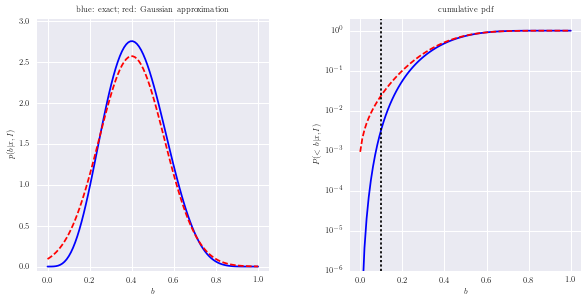

In [12]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm, binom
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Plot posterior as a function of b
n = 10  # number of points
k =  4  # number of successes from n draws

b = np.linspace(0, 1, 100)
db = b[1] - b[0]

# compute the probability p(b) (eqn. 5.70)
p_b = b ** k * (1 - b) ** (n - k)
p_b /= p_b.sum()
p_b /= db
cuml_p_b = p_b.cumsum()
cuml_p_b /= cuml_p_b[-1]

# compute the gaussian approximation (eqn. 5.71)
b0 = k * 1. / n
sigb = np.sqrt(b0*(1-b0)/n)
p_g = norm(b0, sigb).pdf(b)
cuml_p_g = p_g.cumsum()
cuml_p_g /= cuml_p_g[-1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax = fig.add_subplot(121)
ax.plot(b, p_b, '-b')
ax.plot(b, p_g, '--r')

ax.set_ylim(-0.05, np.max(p_b)*1.1)

ax.set_xlabel('$b$')
ax.set_ylabel('$p(b|x,I)$')
plt.title('blue: exact; red: Gaussian approximation')


ax = fig.add_subplot(122, yscale='log')
ax.plot(b, cuml_p_b, '-b')
ax.plot(b, cuml_p_g, '--r')
Jfrac = 0.1
ax.plot([Jfrac, Jfrac], [1E-6, 2], ':k')
plt.title('cumulative pdf')

ax.set_xlabel('$b$')
ax.set_ylabel('$P(<b|x,I)$')
ax.set_ylim(1E-6, 2)

plt.show()

### Parameter estimation for the binomial distribution

For $N=10$ and $k=4$: $p(b < 0.1\,|\,k = 4, N = 10) = 0.003$ and the theory is rejected
at a confidence level $\alpha = 0.01$. 

However, using Gaussian approximation we get 
$p(b < 0.1) = 0.03$ and thus at a confidence level $\alpha = 0.01$ the theory is **not** rejected! 

**Conclusion**: when $N$ is not large, or $b_o$ is close to 0 or 1, one should avoid using the 
Gaussian approximation when estimating the credible region (or the confidence interval) for $b$.

An interesting numerical experiment is to observe how $p(b \,|\, k, N )$ evolves with the number
and outcome of coin flips - this was covered by Andy last week. 

Here, experiment with the above code by changing $k$ and $N$ and observing the bahavior of $p(b)$, and its (dis)agreement with the Gaussian approximation. 

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates
 
 
The above procedure is valid for a given model $M$. For example, we can fit a straight
line to data $\{x_i,y_i\}$. 

**What if we have a competing model?**

For example, how do we know that we should fit a straight line to our data and not, perhaps, 
a parabola, or y=sin(x), etc? 
  

##  Markov Chain Monte Carlo with PyMC

Let's use MCMC to fit a model consisting of a burst signal added to an unknown background.

<img src="figures/book_burst.tiff" alt="Drawing" style="width: 600px;"/>

 

@pickle_results: using precomputed results from 'matchedfilt_burst.pkl'


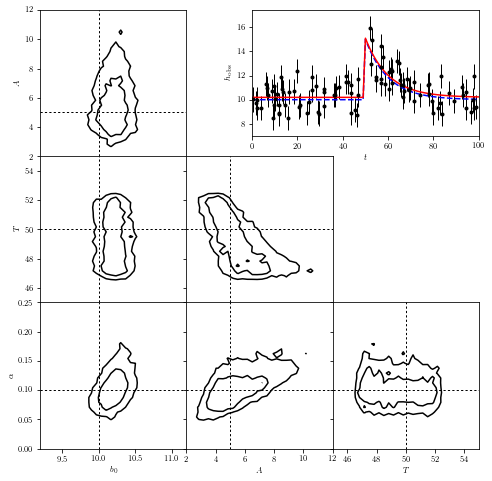

In [4]:
 ### AstroML book figure 10.25

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)


#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

**It is easy to modify the code to use other profiles. Let's try a Gaussian profile! **

 [-----------------100%-----------------] 25000 of 25000 complete in 5.8 sec

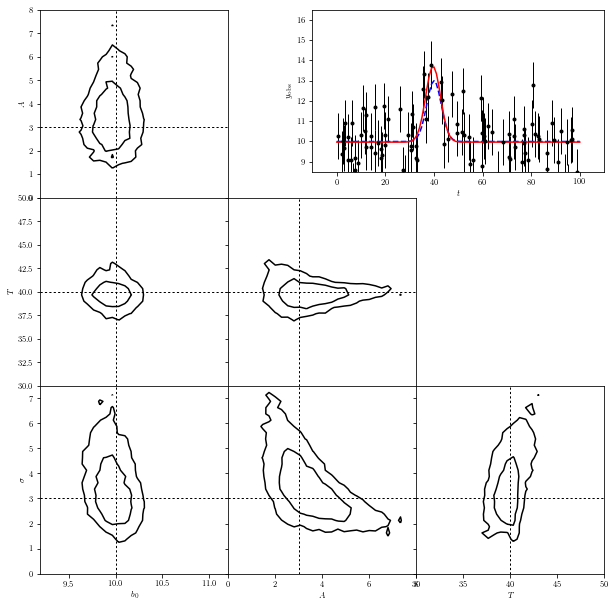

In [5]:
 ### Modeled after AstroML book figure 10.25
## burst model replaced by gaussian profile

#----------------------------------------------------------------------
# Set up toy dataset
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

np.random.seed(42)
N = 101
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40
err0_y = 0.5

t = 100 * np.random.random(N)
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)

labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']
limits = [(9.2, 11.2), (0, 8), (30, 50), (0.0, 7.5)]
true = [b0_true, A_true, T_true, sigma_true]

#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = GaussAndBkgd(t_fit, *fit_vals)
y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, err_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(-10, 110)
ax.set_ylim(8.5, 16.5)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()